In [ ]:
"""This notebook is used to perform the parameter-tuning for the classifier"""

import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV 

import matplotlib.pylab as plt
%matplotlib inline

import importlib
from main import *
importlib.reload(main)


In [32]:
from main import dtrain as train_df

In [33]:
"""Function to train a classifier with chosen parameters. 
   For any classifier Stratified-CV is perfomerd with 10 folds, to ensure equal distribution of examples regarding 
   the classes of accident severity.
   Moreover the classifier is retrained on the whole training dataset with the chosen parameters and accuracy is 
   calculated.
   
   If not None for early_stopping_rounds parameter is chosen, early stopping will be performed after 75 rounds.
"""

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=10, early_stopping_rounds=75):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain["Unfallschwere"].values, 
                              feature_names = predictors)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
             metrics=['merror'], early_stopping_rounds=early_stopping_rounds, verbose_eval=True, stratified=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Unfallschwere'],eval_metric=['merror'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Unfallschwere'].values, dtrain_predictions))
    
    fig, ax = plt.subplots(1,1,figsize=(20,18))
    xgb.plot_importance(alg, ax=ax)
    

[0]	train-merror:0.111243+0.000682937	test-merror:0.113641+0.00134515
[1]	train-merror:0.111206+0.00104422	test-merror:0.113443+0.00168043
[2]	train-merror:0.111718+0.000928518	test-merror:0.113377+0.00149214
[3]	train-merror:0.111674+0.000814525	test-merror:0.113706+0.00136171
[4]	train-merror:0.111769+0.000624065	test-merror:0.113443+0.00140981
[5]	train-merror:0.111645+0.000631063	test-merror:0.11318+0.00146133
[6]	train-merror:0.11155+0.000743944	test-merror:0.112916+0.00117998
[7]	train-merror:0.111294+0.00063406	test-merror:0.113246+0.00133201
[8]	train-merror:0.111228+0.000524209	test-merror:0.113114+0.00158823
[9]	train-merror:0.111089+0.000563518	test-merror:0.112983+0.00117811
[10]	train-merror:0.111169+0.000507331	test-merror:0.113312+0.00158532
[11]	train-merror:0.110994+0.000474535	test-merror:0.113114+0.00144176
[12]	train-merror:0.110958+0.000421433	test-merror:0.11318+0.00150241
[13]	train-merror:0.110906+0.000455865	test-merror:0.112983+0.00144542
[14]	train-merror:0.1

[116]	train-merror:0.0982723+0.000774234	test-merror:0.112455+0.00245995
[117]	train-merror:0.0981625+0.000741499	test-merror:0.112521+0.00229085
[118]	train-merror:0.0980604+0.000740056	test-merror:0.112389+0.00233164
[119]	train-merror:0.0978407+0.000705041	test-merror:0.112389+0.00232754
[120]	train-merror:0.0977825+0.000733989	test-merror:0.112653+0.00226858
[121]	train-merror:0.0977166+0.000853602	test-merror:0.11285+0.00237034
[122]	train-merror:0.0975338+0.000781661	test-merror:0.11285+0.00233772
[123]	train-merror:0.0974535+0.00077013	test-merror:0.112784+0.00212863
[124]	train-merror:0.0973951+0.000687574	test-merror:0.112653+0.0021243
[125]	train-merror:0.0972782+0.000759545	test-merror:0.112784+0.00203643
[126]	train-merror:0.0971097+0.000750938	test-merror:0.112719+0.00185831
[127]	train-merror:0.0969562+0.000868361	test-merror:0.11285+0.00188683
[128]	train-merror:0.0968758+0.000857994	test-merror:0.112784+0.00209227
[129]	train-merror:0.0967223+0.000840262	test-merror:0.1

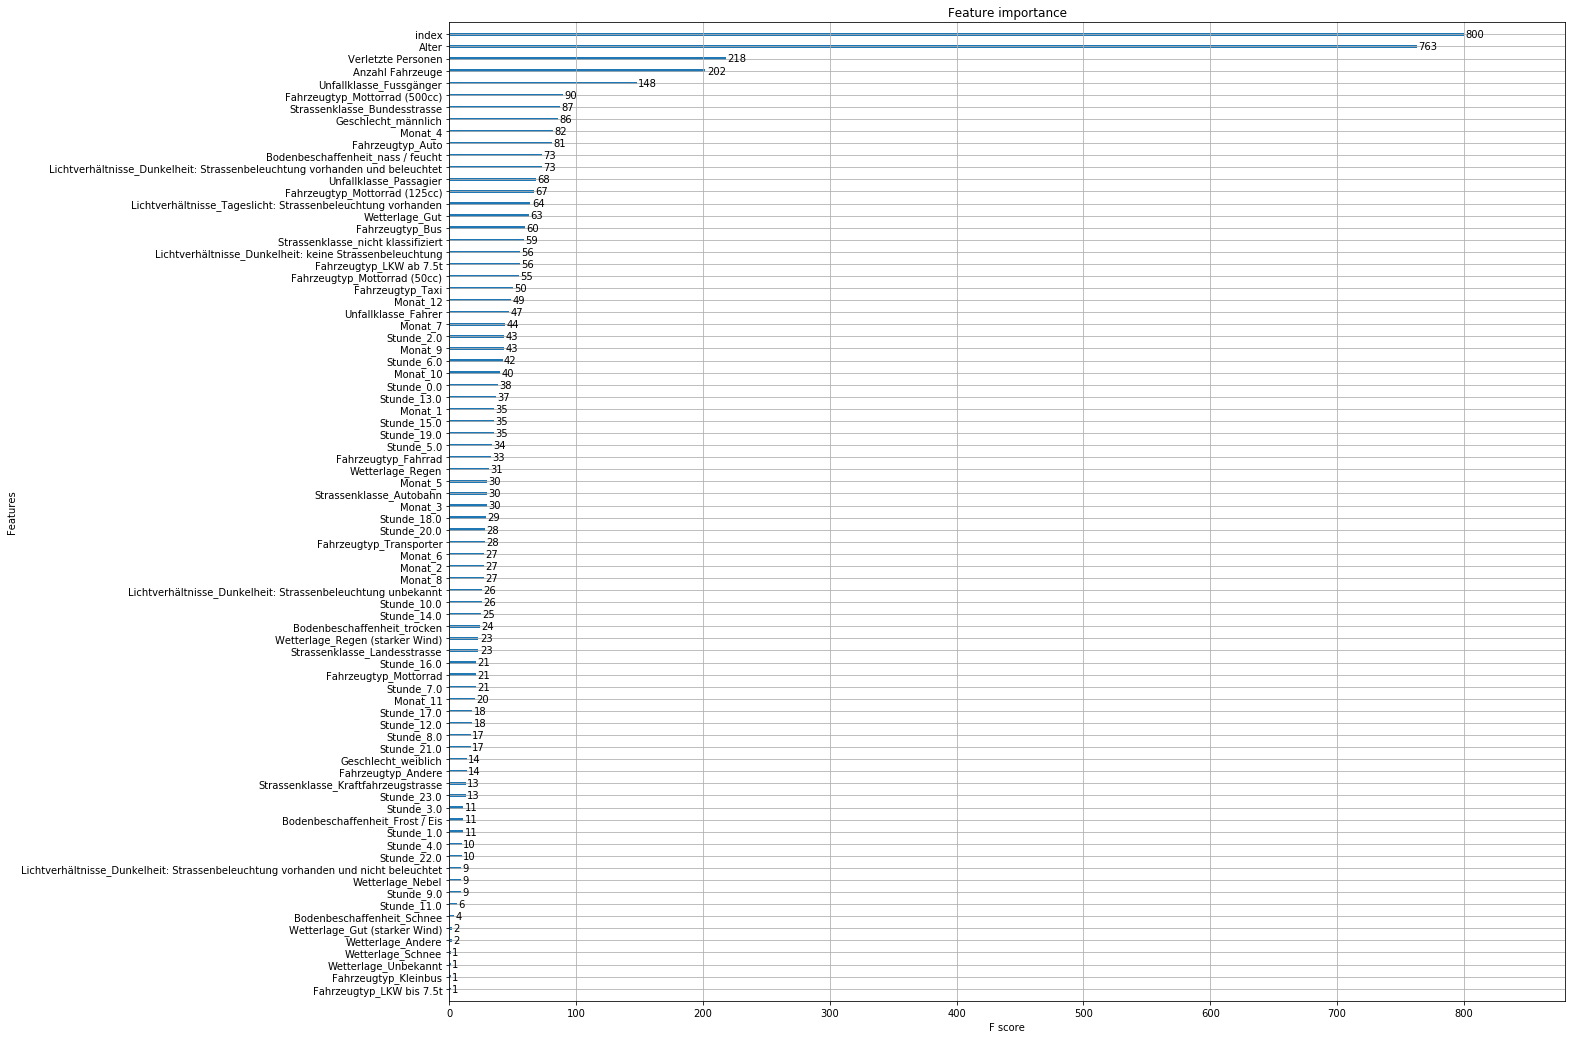

In [34]:
features = [f for f in train_df.columns if f not in ["Unfallschwere"]]
#first training to determine the best number for n_estimators
xgb1 = XGBClassifier(
 learning_rate =0.1,
 num_class = 4,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= "multi:softmax",
 nthread=4,
 scale_pos_weight=1,
 seed=1337)

modelfit(xgb1, train_df, features)

In [185]:
#First test to tune max_depth and min_child_weight
param_test1 = {
 'max_depth':range(3,8,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=50, max_depth=4, num_class=4,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= "multi:softmax", nthread=4, scale_pos_weight=1, seed=1337), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=10)

gsearch1.fit(train_df[features],train_df["Unfallschwere"])

gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.88662, std: 0.00084, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.88669, std: 0.00085, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.88682, std: 0.00079, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.88649, std: 0.00107, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: 0.88656, std: 0.00099, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.88642, std: 0.00067, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.88695, std: 0.00103, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: 0.88689, std: 0.00076, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.88669, std: 0.00115, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.88649, std: 0.00125, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.88642, std: 0.00116, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.88675, std: 0.00147, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: 0.88656, std: 0.00118, params: {

In [188]:
#second test to tune gamma parameter
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)],
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=50, max_depth=4, num_class=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= "multi:softmax", nthread=4, scale_pos_weight=1, seed=1337), 
 param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=10)

gsearch2.fit(train_df[features],train_df["Unfallschwere"])

gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.88695, std: 0.00103, params: {'gamma': 0.0},
  mean: 0.88649, std: 0.00112, params: {'gamma': 0.1},
  mean: 0.88662, std: 0.00090, params: {'gamma': 0.2},
  mean: 0.88669, std: 0.00112, params: {'gamma': 0.3},
  mean: 0.88662, std: 0.00106, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.8869511903355312)

[0]	train-merror:0.112551+0.000835354	test-merror:0.113444+0.00722699
[1]	train-merror:0.112741+0.00105098	test-merror:0.113378+0.00681092
[2]	train-merror:0.112647+0.000883579	test-merror:0.113575+0.00684926
[3]	train-merror:0.112844+0.000910008	test-merror:0.113378+0.00709717
[4]	train-merror:0.11291+0.000920893	test-merror:0.113641+0.00690057
[5]	train-merror:0.112793+0.000953444	test-merror:0.113773+0.00706949
[6]	train-merror:0.112749+0.000980774	test-merror:0.113312+0.00683493
[7]	train-merror:0.1128+0.000913002	test-merror:0.113575+0.00697525
[8]	train-merror:0.1128+0.000887697	test-merror:0.11351+0.00685673
[9]	train-merror:0.112815+0.000926892	test-merror:0.113575+0.00684988
[10]	train-merror:0.112771+0.000956725	test-merror:0.113575+0.00681186
[11]	train-merror:0.11269+0.000986075	test-merror:0.113444+0.00681157
[12]	train-merror:0.112566+0.000931706	test-merror:0.11351+0.00679967
[13]	train-merror:0.112573+0.000910792	test-merror:0.11351+0.00693832
[14]	train-merror:0.112515

[117]	train-merror:0.106249+0.000896281	test-merror:0.113641+0.00814989
[118]	train-merror:0.106147+0.000922562	test-merror:0.113707+0.00813834
[119]	train-merror:0.106066+0.000931528	test-merror:0.113707+0.0081702
[120]	train-merror:0.106015+0.00098834	test-merror:0.113575+0.00823015
[121]	train-merror:0.10592+0.000965012	test-merror:0.113575+0.00823015
[122]	train-merror:0.105883+0.000943676	test-merror:0.113575+0.00823015
[123]	train-merror:0.105803+0.00091421	test-merror:0.113444+0.0082358
[124]	train-merror:0.105774+0.000934227	test-merror:0.113378+0.00826615
[125]	train-merror:0.105744+0.000909894	test-merror:0.113444+0.00825089
[126]	train-merror:0.105657+0.000914788	test-merror:0.113444+0.00818782
[127]	train-merror:0.105613+0.000991797	test-merror:0.113641+0.00833842
[128]	train-merror:0.105598+0.000985824	test-merror:0.113509+0.00843719
[129]	train-merror:0.105503+0.000949717	test-merror:0.113575+0.00835438
[130]	train-merror:0.105489+0.000947946	test-merror:0.113575+0.008354

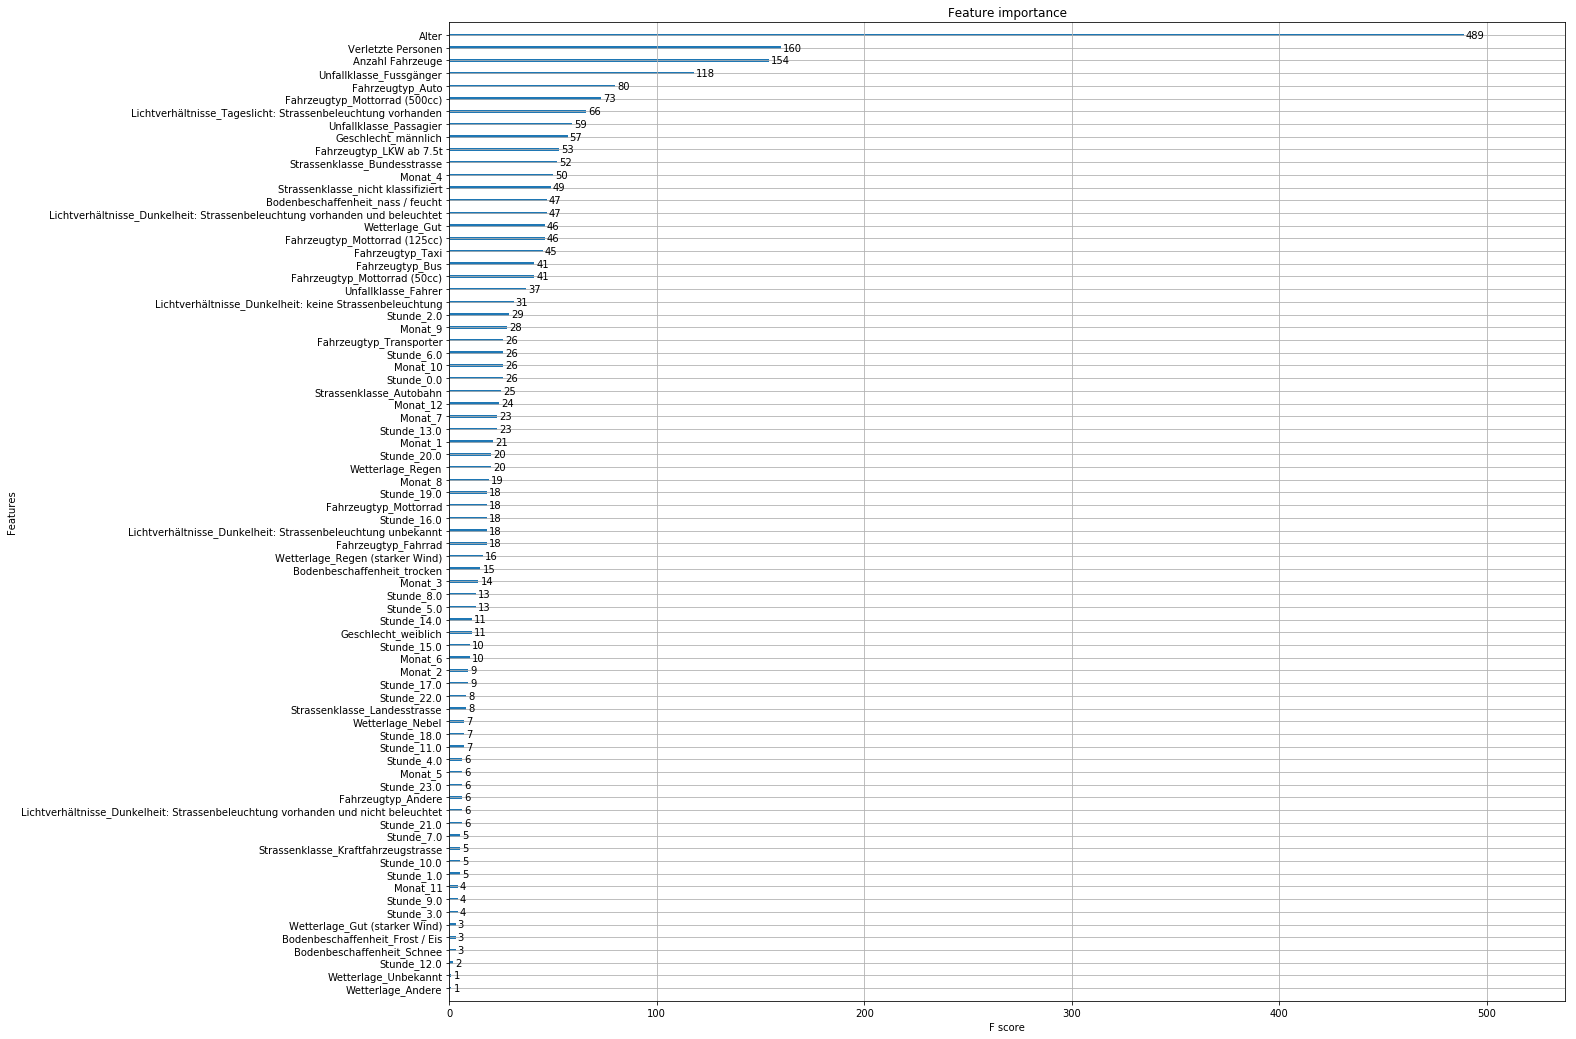

In [190]:
#again determin best number for n_estimators with best values for the latter parameters
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 num_class=4,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 seed=1337)
modelfit(xgb2, train_df, features)

In [191]:
#4th test to tune subsamle and colsample_bytree parameter
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=1337), 
 param_grid = param_test4, scoring='accuracy',n_jobs=4,iid=False, cv=10)
gsearch4.fit(train_df[features],train_df["Unfallschwere"])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.88695, std: 0.00151, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.88708, std: 0.00147, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.88662, std: 0.00114, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.88629, std: 0.00104, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.88662, std: 0.00187, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.88695, std: 0.00165, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.88669, std: 0.00112, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.88643, std: 0.00106, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.88669, std: 0.00154, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.88662, std: 0.00132, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.88629, std: 0.00102, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.88675, std: 0.00123, params: {'colsample_bytree': 0.8, 'subsample'

In [195]:
#additional to further tune colsample_bytree parameter
param_test4b = {
 'colsample_bytree':[i/10.0 for i in range(1,7)]
}
gsearch4b = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.8,
 objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=1337), 
 param_grid = param_test4b, scoring='accuracy',n_jobs=4,iid=False, cv=10)
gsearch4b.fit(train_df[features],train_df["Unfallschwere"])
gsearch4b.grid_scores_, gsearch4b.best_params_, gsearch4b.best_score_

([mean: 0.88675, std: 0.00064, params: {'colsample_bytree': 0.1},
  mean: 0.88669, std: 0.00155, params: {'colsample_bytree': 0.2},
  mean: 0.88669, std: 0.00180, params: {'colsample_bytree': 0.3},
  mean: 0.88656, std: 0.00188, params: {'colsample_bytree': 0.4},
  mean: 0.88689, std: 0.00198, params: {'colsample_bytree': 0.5},
  mean: 0.88708, std: 0.00147, params: {'colsample_bytree': 0.6}],
 {'colsample_bytree': 0.6},
 0.8870830290923168)

In [208]:
#6th test to tune reg_alpha parameter (L1-Regularization)
param_test6 = {
 'reg_alpha':[0.1, 0.15, 0.2, 0.25, 0.3]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.6,
 objective= 'multi:logistic', nthread=4, scale_pos_weight=1,seed=1337), 
 param_grid = param_test6, scoring='accuracy',n_jobs=4,iid=False, cv=10)
gsearch6.fit(train_df[features],train_df["Unfallschwere"])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.88689, std: 0.00149, params: {'reg_alpha': 0.1},
  mean: 0.88675, std: 0.00168, params: {'reg_alpha': 0.15},
  mean: 0.88721, std: 0.00137, params: {'reg_alpha': 0.2},
  mean: 0.88715, std: 0.00153, params: {'reg_alpha': 0.25},
  mean: 0.88689, std: 0.00165, params: {'reg_alpha': 0.3}],
 {'reg_alpha': 0.2},
 0.887214305147141)

In [211]:
#6th test to tune reg_lambda parameter (L2-Regularization)

param_test7 = {
 'reg_lambda': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=4,
 min_child_weight=2, gamma=0, subsample=0.7, colsample_bytree=0.6, reg_alpha=0.2,
 objective= 'multi:logistic', nthread=4, scale_pos_weight=1,seed=1337), 
 param_grid = param_test6, scoring='accuracy',n_jobs=4,iid=False, cv=10)
gsearch7.fit(train_df[features],train_df["Unfallschwere"])
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.88754, std: 0.00177, params: {'reg_lambda': 1e-05},
  mean: 0.88721, std: 0.00148, params: {'reg_lambda': 0.01},
  mean: 0.88695, std: 0.00154, params: {'reg_lambda': 0.1},
  mean: 0.88721, std: 0.00137, params: {'reg_lambda': 1},
  mean: 0.88689, std: 0.00165, params: {'reg_lambda': 100}],
 {'reg_lambda': 1e-05},
 0.8875435990610786)

[0]	train-merror:0.112325+0.000522011	test-merror:0.113838+0.00104518
[1]	train-merror:0.11269+0.000443403	test-merror:0.113312+0.000599162
[2]	train-merror:0.112888+0.000523516	test-merror:0.113509+0.000852327
[3]	train-merror:0.112961+0.000521143	test-merror:0.113443+0.000736178
[4]	train-merror:0.112976+0.000550958	test-merror:0.113377+0.000972368
[5]	train-merror:0.113056+0.000559502	test-merror:0.113509+0.000953734
[6]	train-merror:0.113151+0.0003624	test-merror:0.113509+0.00075009
[7]	train-merror:0.113158+0.000314729	test-merror:0.113377+0.000722503
[8]	train-merror:0.113209+0.000265949	test-merror:0.113443+0.000674742
[9]	train-merror:0.113253+0.000261908	test-merror:0.113443+0.000674742
[10]	train-merror:0.113209+0.000282268	test-merror:0.113443+0.000674742
[11]	train-merror:0.113158+0.000295863	test-merror:0.113311+0.000761634
[12]	train-merror:0.113129+0.000314889	test-merror:0.113246+0.000615898
[13]	train-merror:0.113071+0.000409824	test-merror:0.113246+0.000615898
[14]	tr

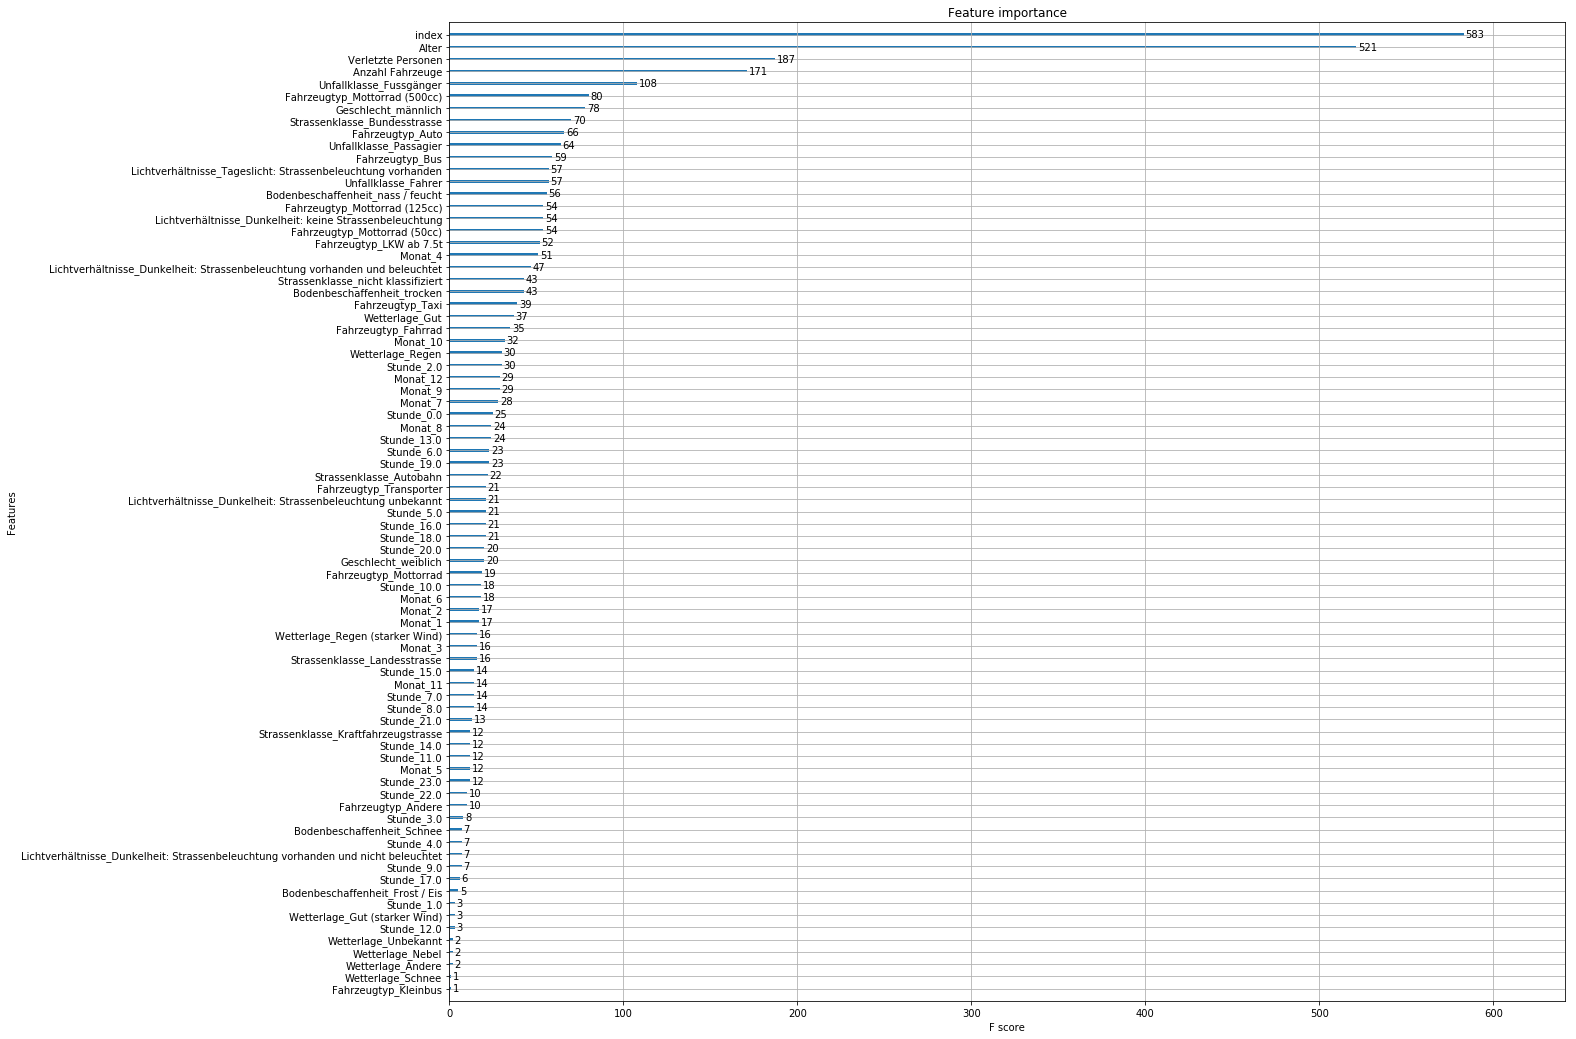

In [35]:
#again determine best number for n_estimators with best values for the parameters at this point

xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 num_class=4,
 max_depth=4,
 min_child_weight=2,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.6,
 objective= 'multi:softmax',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha=0.2,
 reg_lambda=1e-05,
 seed=1337)
modelfit(xgb3, train_df, features, early_stopping_rounds = None)

In [37]:
features = [f for f in train_df.columns if f not in ["Unfallschwere"]]
#first training to determine the best number for n_estimators
xgb1 = XGBClassifier(
 learning_rate =0.1,
 num_class = 4,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= "multi:softmax",
 nthread=4,
 scale_pos_weight=1,
 seed=1337)

modelfit(xgb1, dtrain, features)

[0]	train-merror:0.111243+0.000682937	test-merror:0.113641+0.00134515
[1]	train-merror:0.111206+0.00104422	test-merror:0.113443+0.00168043
[2]	train-merror:0.111718+0.000928518	test-merror:0.113377+0.00149214


KeyboardInterrupt: 